# Prepare (Training) Data

In [3]:
# IMPORT LIBRARIES
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from skimage import io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# SET WORKING DIRECTORY
os.chdir('/Users/hienhuynh/Documents/Python Codes/DSS Thesis/DeepPhotoAesthetics/')

In [4]:
# CREATE DATASET
class CreateDataset(Dataset):
    def __init__(self, df, is_train):
        self.df = df
        normalize_transform = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
        
        if is_train:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([299, 299]),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize_transform])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([299, 299]),
                transforms.ToTensor(),
                normalize_transform])
            
    def get_target(self, df_row):
        target_dict = {}
        for key, value in df_row.to_dict().items():
            if key in ['ImageFile','ImageDir']:
                continue
            target_dict[key] = torch.from_numpy(np.array([value]))
        return target_dict
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        df_row = self.df.loc[index]
        image_dir = df_row['ImageDir']
        image = io.imread(image_dir)
        image = self.transform(image)
        target = self.get_target(df_row)
        return {"image":image,"image_dir":image_dir,**target}

In [13]:
# MERGE ORIGINAL TRAIN-VAL-TEST CSV FILES
try:
    df = pd.read_csv('./data/photo_aesthetics.csv')
except:
    paths = ['./data/train.csv','./data/test.csv','./data/val.csv']
    df = pd.DataFrame()
    for path in paths:
        temp = pd.read_csv(path)
        df = pd.concat([df,temp],ignore_index=True)
    df.reset_index(drop=True,inplace=True)
    # APPEND DIRECTORIES TO IMAGE FILENAMES
    df['ImageDir'] = df['ImageFile'].apply(lambda x: f'./images/{x}')
    # EXTRACT SHAPES OF IMAGES
    df['ImageShape'] = df['ImageDir'].apply(lambda y: io.imread(y).shape)
    # REMOVE GRAYSCALE IMAGES (LENGTH OF SHAPE != 3)
    df = df[df['ImageShape'].map(lambda z: len(z)==3)]
    # KEEP CERTAIN COLUMNS
    df = df[['ImageFile','ImageDir','score']]
    # SAVE DF TO CSV FILE
    df.to_csv('./data/photo_aesthetics.csv',index=False)

In [14]:
# SPLIT DF INTO TRAIN & VALIDATION
train_df, val_df = train_test_split(df, test_size=0.2, random_state=2023)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=2023)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)

In [15]:
# CREATE & LOAD DATASETS
train = CreateDataset(train_df,True)
val = CreateDataset(val_df,False)
test= CreateDataset(test_df,False)
train = DataLoader(train,batch_size=16)
val = DataLoader(val,batch_size=16)
test = DataLoader(test,batch_size=16)

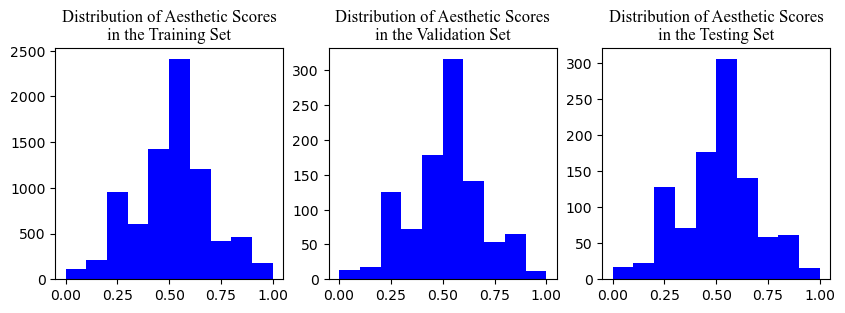

In [77]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.hist(train_df['score'].to_list(),color='blue')
plt.title('Distribution of Aesthetic Scores\nin the Training Set',fontname='Times New Roman')
plt.subplot(1,3,2)
plt.hist(val_df['score'].to_list(),color='blue')
plt.title('Distribution of Aesthetic Scores\nin the Validation Set',fontname='Times New Roman')
plt.subplot(1,3,3)
plt.hist(test_df['score'].to_list(),color='blue')
plt.title('Distribution of Aesthetic Scores\nin the Testing Set',fontname='Times New Roman')
plt.savefig('./checkpoint/loss_plot/data_distrib.png',dpi=1200,bbox_inches = "tight")

In [78]:
train_df.shape[0]

7956

In [79]:
val_df.shape[0]

995

In [80]:
test_df.shape[0]

995

# Model

In [5]:
# IMPORT LIBRARIES
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import models
from torch.autograd import Variable
from collections import defaultdict
from scipy.stats import pearsonr
from tqdm import tqdm

In [6]:
# MODEL SPECIFICATIONS
class PoolFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_maps = None

    def forward(self, inp):
        kernel_size = (inp.size()[2], inp.size()[3])
        self.feature_maps = F.avg_pool2d(inp, kernel_size)
        return inp


class FeaturesMap(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_maps = None

    def forward(self, inp):
        self.feature_maps = inp
        return inp


class ResNetGAPFeatures(nn.Module):
    def __init__(self, resnet, n_features=1):
        super().__init__()
        self.model = nn.Sequential(*list(resnet.children())[:4])
        self.all_features = []
        self.all_pooled_features = []
        self.attribute_weights = nn.Linear(15104, n_features)

        count = 0
        for i, mod in enumerate(list(resnet.children())):
            # Extract the bottleneck layers
            if isinstance(mod, nn.Sequential):
                for bn in mod:
                    self.model.add_module(f"bn_{count}", bn)

                    # Use "Transparent layers and save references to their objects for later use"
                    pooled_feature_map = PoolFeatures()
                    feature_map = FeaturesMap()
                    self.model.add_module(f"pooled_feature_{count}", pooled_feature_map)
                    self.model.add_module(f"feature_map_{count}", feature_map)
                    self.all_pooled_features.append(pooled_feature_map)
                    self.all_features.append(feature_map)
                    count += 1

    def forward(self, inp):
        _ = self.model(inp)
        features = torch.cat([pool_fp.feature_maps for pool_fp in self.all_pooled_features], dim=1).squeeze()
        features = F.dropout(features, p=0.2)
        if len(features.size()) == 1:
            features = features.unsqueeze(0)

        # Use features to predict scores
        attribute_scores = self.attribute_weights(features)
        
        # The last 3 scores reflect
        # 'Repetition', 'Symmetry', 'score' which are between values 0 and 1
        # hence the sigmoid non-linearity
        non_neg_attr = F.sigmoid(attribute_scores)
        predictions = torch.cat([non_neg_attr], dim=1)
        return predictions

def resnet_gap_features():
    resnet = models.resnet50(pretrained=True)
    model = ResNetGAPFeatures(resnet)
    return model

In [7]:
# OTHER SUPPORT FUNCTIONS
def create_all_targets(data, attributes):
    targets = []
    for attr in attributes:
        targets.append(data[attr])
    targets = Variable(torch.cat(targets, dim=1)).float()
    return targets

def update_results(epoch, predictions, targets, loss, weights, all_attributes, loss_data_for_df, corr_data_for_df):
    total_loss_per_sample = torch.sum(loss.data * weights, dim=1).to('cpu')
    masked_loss = (loss.data * weights).to('cpu')
    current_batch_size = loss.size()[0]
    for i in range(current_batch_size):
        for j, k in enumerate(all_attributes):
            loss_data_for_df[k].append(masked_loss[i, j].to('cpu'))
        loss_data_for_df["total_loss"].append(total_loss_per_sample[i])
        loss_data_for_df["epoch"].append(epoch)
    for j, k in enumerate(all_attributes):
        corr_data_for_df[k].append(pearsonr(predictions[:, j].data.cpu().numpy(), targets[:, j].data.cpu().numpy())[0])
    corr_data_for_df["epoch"].append(epoch)

In [10]:
# HYPERPARAMETERS
# MPS DEVICE
mps_device = torch.device("mps")
# MODEL
model = resnet_gap_features()
model = model.to(mps_device)
# LEARNING RATE
fc_lr = 1e-5
# FINE TUNE LEARNING RATE
fine_tune_lr = 1e-6
# NUMBER OF EPOCHS
n_epochs = 20
# LABELS
all_attributes = ['score']
# OPTIMIZER
ignored_params = list(map(id, model.attribute_weights.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params, model.parameters())
optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': model.attribute_weights.parameters(), 'lr': fc_lr, 'weight_decay': 0.1}
], lr=fine_tune_lr)
# LOSS FUNCTION
criterion = nn.MSELoss(reduce=False)
# WEIGHTS
weights = torch.zeros(1, len(all_attributes)).to(mps_device)
loss_weights = {'score':1.0}
for i, attr in enumerate(all_attributes):
    weight = loss_weights[attr]
    weights[0, i] = weight
# SAVE PATH
save_path = "./checkpoint_03/"
if not os.path.exists(save_path):
    os.mkdir(save_path)
train_loss, train_corr, val_loss, val_corr = [],[],[],[]

/Users/hienhuynh/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hienhuynh/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/hienhuynh/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [11]:
for epoch in tqdm(range(n_epochs)):
    train_loss_data_for_epoch = defaultdict(list)
    train_correlation_data_for_epoch = defaultdict(list)
    val_loss_data_for_epoch = defaultdict(list)
    val_correlation_data_for_epoch = defaultdict(list)

    for data in tqdm(train):
        model.train()
        inp = Variable(data['image'])
        inp = inp.to(mps_device)
        predictions = model(inp)
        targets = create_all_targets(data, all_attributes)
        targets = targets.to(mps_device)
        loss = criterion(predictions, targets).to(mps_device)

        # Update results
        update_results(epoch, predictions, targets, loss, weights,
                       all_attributes, train_loss_data_for_epoch,
                       train_correlation_data_for_epoch)

        # Update gradients
        optimizer.zero_grad()
        torch.autograd.backward(torch.sum(loss, dim=0).unsqueeze(0), weights)
        optimizer.step()

    train_correlation_df_for_epoch = pd.DataFrame(train_correlation_data_for_epoch)
    train_corr.append(train_correlation_df_for_epoch)
    train_loss_df_for_epoch = pd.DataFrame(train_loss_data_for_epoch)
    train_loss.append(train_loss_df_for_epoch)

    print(f"\nTraining Loss Breakdown:\n{train_loss_df_for_epoch.mean()}")
    print(f"\nTraining Correlation Breakdown:\n{train_correlation_df_for_epoch.mean()}")

    for data in tqdm(val):
        model.eval()
        inp = Variable(data['image'])
        inp = inp.to(mps_device)
        predictions = model(inp)
        targets = create_all_targets(data, all_attributes)
        targets = targets.to(mps_device)
        loss = criterion(predictions, targets).to(mps_device)

        # Update results
        update_results(epoch, predictions, targets, loss, weights,
                       all_attributes, val_loss_data_for_epoch,
                       val_correlation_data_for_epoch)

    val_correlation_df_for_epoch = pd.DataFrame(val_correlation_data_for_epoch)
    val_corr.append(val_correlation_df_for_epoch)
    val_loss_df_for_epoch = pd.DataFrame(val_loss_data_for_epoch)
    val_loss.append(val_loss_df_for_epoch)
    print(f"\nValidation Loss Breakdown:\n{val_loss_df_for_epoch.mean()}")
    print(f"\nValidation Correlation Breakdown:\n{val_correlation_df_for_epoch.mean()}")


    torch.save(model.state_dict(), f"{save_path}/epoch_{epoch}.loss_{val_loss_df_for_epoch.mean()['total_loss']}.pth")


train_loss = pd.DataFrame(pd.concat(train_loss))
val_loss = pd.DataFrame(pd.concat(val_loss))
train_loss.to_csv(f"{save_path}/train_results.csv")
val_loss.to_csv(f"{save_path}/val_results.csv")

train_corr = pd.DataFrame(pd.concat(train_corr))
val_corr = pd.DataFrame(pd.concat(val_corr))
train_corr.to_csv(f"{save_path}/train_corr_results.csv")
val_corr.to_csv(f"{save_path}/val_corr_results.csv")


 39%|███████████████▊                         | 192/498 [02:16<03:34,  1.43it/s]


 78%|███████████████████████████████▊         | 386/498 [04:31<01:17,  1.44it/s]


100%|█████████████████████████████████████████| 498/498 [05:51<00:00,  1.42it/s]



Training Loss Breakdown:
score         0.031032
total_loss    0.031032
epoch         0.000000
dtype: float64

Training Correlation Breakdown:
score    0.343204
epoch    0.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:14<00:00,  4.24it/s]



Validation Loss Breakdown:
score         0.024705
total_loss    0.024705
epoch         0.000000
dtype: float64

Validation Correlation Breakdown:
score    0.496887
epoch    0.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:13<03:33,  1.43it/s]


 78%|███████████████████████████████▊         | 386/498 [04:28<01:17,  1.45it/s]


100%|█████████████████████████████████████████| 498/498 [05:46<00:00,  1.44it/s]



Training Loss Breakdown:
score         0.025788
total_loss    0.025788
epoch         1.000000
dtype: float64

Training Correlation Breakdown:
score    0.533238
epoch    1.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.52it/s]



Validation Loss Breakdown:
score         0.021901
total_loss    0.021901
epoch         1.000000
dtype: float64

Validation Correlation Breakdown:
score    0.564438
epoch    1.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:13<03:36,  1.41it/s]


 78%|███████████████████████████████▊         | 386/498 [04:28<01:18,  1.43it/s]


100%|█████████████████████████████████████████| 498/498 [05:46<00:00,  1.44it/s]



Training Loss Breakdown:
score         0.023197
total_loss    0.023197
epoch         2.000000
dtype: float64

Training Correlation Breakdown:
score    0.595277
epoch    2.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.50it/s]



Validation Loss Breakdown:
score         0.020629
total_loss    0.020629
epoch         2.000000
dtype: float64

Validation Correlation Breakdown:
score    0.596066
epoch    2.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:13<03:34,  1.43it/s]


 78%|███████████████████████████████▊         | 386/498 [04:28<01:17,  1.44it/s]


100%|█████████████████████████████████████████| 498/498 [05:46<00:00,  1.44it/s]



Training Loss Breakdown:
score         0.021428
total_loss    0.021428
epoch         3.000000
dtype: float64

Training Correlation Breakdown:
score    0.637138
epoch    3.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.53it/s]



Validation Loss Breakdown:
score         0.020675
total_loss    0.020675
epoch         3.000000
dtype: float64

Validation Correlation Breakdown:
score    0.592747
epoch    3.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:13<03:35,  1.42it/s]


 78%|███████████████████████████████▊         | 386/498 [04:28<01:17,  1.44it/s]


100%|█████████████████████████████████████████| 498/498 [05:46<00:00,  1.44it/s]



Training Loss Breakdown:
score         0.020311
total_loss    0.020311
epoch         4.000000
dtype: float64

Training Correlation Breakdown:
score    0.661104
epoch    4.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.54it/s]



Validation Loss Breakdown:
score         0.020537
total_loss    0.020537
epoch         4.000000
dtype: float64

Validation Correlation Breakdown:
score    0.594292
epoch    4.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:13<03:35,  1.42it/s]


 78%|███████████████████████████████▊         | 386/498 [04:28<01:18,  1.43it/s]


100%|█████████████████████████████████████████| 498/498 [05:46<00:00,  1.44it/s]



Training Loss Breakdown:
score         0.019075
total_loss    0.019075
epoch         5.000000
dtype: float64

Training Correlation Breakdown:
score    0.688173
epoch    5.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.52it/s]



Validation Loss Breakdown:
score         0.020124
total_loss    0.020124
epoch         5.000000
dtype: float64

Validation Correlation Breakdown:
score    0.60662
epoch    5.00000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:13<03:36,  1.42it/s]


 78%|███████████████████████████████▊         | 386/498 [04:29<01:18,  1.43it/s]


100%|█████████████████████████████████████████| 498/498 [05:46<00:00,  1.44it/s]



Training Loss Breakdown:
score         0.018073
total_loss    0.018073
epoch         6.000000
dtype: float64

Training Correlation Breakdown:
score    0.710742
epoch    6.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.52it/s]



Validation Loss Breakdown:
score         0.020303
total_loss    0.020303
epoch         6.000000
dtype: float64

Validation Correlation Breakdown:
score    0.606576
epoch    6.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:13<03:33,  1.43it/s]


 78%|███████████████████████████████▊         | 386/498 [04:28<01:17,  1.44it/s]


100%|█████████████████████████████████████████| 498/498 [05:46<00:00,  1.44it/s]



Training Loss Breakdown:
score         0.016994
total_loss    0.016994
epoch         7.000000
dtype: float64

Training Correlation Breakdown:
score    0.734117
epoch    7.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:14<00:00,  4.40it/s]



Validation Loss Breakdown:
score         0.020427
total_loss    0.020427
epoch         7.000000
dtype: float64

Validation Correlation Breakdown:
score    0.608529
epoch    7.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:13<03:35,  1.42it/s]


 78%|███████████████████████████████▊         | 386/498 [04:28<01:17,  1.45it/s]


100%|█████████████████████████████████████████| 498/498 [05:45<00:00,  1.44it/s]



Training Loss Breakdown:
score         0.016094
total_loss    0.016094
epoch         8.000000
dtype: float64

Training Correlation Breakdown:
score    0.752408
epoch    8.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:14<00:00,  4.49it/s]



Validation Loss Breakdown:
score         0.02031
total_loss    0.02031
epoch         8.00000
dtype: float64

Validation Correlation Breakdown:
score    0.612877
epoch    8.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:12<03:35,  1.42it/s]


 78%|███████████████████████████████▊         | 386/498 [04:26<01:17,  1.44it/s]


100%|█████████████████████████████████████████| 498/498 [05:44<00:00,  1.45it/s]



Training Loss Breakdown:
score         0.015163
total_loss    0.015163
epoch         9.000000
dtype: float64

Training Correlation Breakdown:
score    0.770278
epoch    9.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.56it/s]



Validation Loss Breakdown:
score         0.020574
total_loss    0.020574
epoch         9.000000
dtype: float64

Validation Correlation Breakdown:
score    0.610305
epoch    9.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:13<03:37,  1.41it/s]


 78%|███████████████████████████████▊         | 386/498 [04:27<01:17,  1.44it/s]


100%|█████████████████████████████████████████| 498/498 [05:44<00:00,  1.44it/s]



Training Loss Breakdown:
score          0.014195
total_loss     0.014195
epoch         10.000000
dtype: float64

Training Correlation Breakdown:
score     0.789288
epoch    10.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.55it/s]



Validation Loss Breakdown:
score          0.020919
total_loss     0.020919
epoch         10.000000
dtype: float64

Validation Correlation Breakdown:
score     0.607938
epoch    10.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:13<03:35,  1.42it/s]


 78%|███████████████████████████████▊         | 386/498 [04:28<01:17,  1.44it/s]


100%|█████████████████████████████████████████| 498/498 [05:45<00:00,  1.44it/s]



Training Loss Breakdown:
score          0.013321
total_loss     0.013321
epoch         11.000000
dtype: float64

Training Correlation Breakdown:
score     0.80577
epoch    11.00000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.53it/s]



Validation Loss Breakdown:
score          0.021059
total_loss     0.021059
epoch         11.000000
dtype: float64

Validation Correlation Breakdown:
score     0.608204
epoch    11.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:14<03:35,  1.42it/s]


 78%|███████████████████████████████▊         | 386/498 [04:30<01:18,  1.44it/s]


100%|█████████████████████████████████████████| 498/498 [05:48<00:00,  1.43it/s]



Training Loss Breakdown:
score          0.012287
total_loss     0.012287
epoch         12.000000
dtype: float64

Training Correlation Breakdown:
score     0.826195
epoch    12.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:14<00:00,  4.43it/s]



Validation Loss Breakdown:
score          0.021467
total_loss     0.021467
epoch         12.000000
dtype: float64

Validation Correlation Breakdown:
score     0.605232
epoch    12.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:15<03:36,  1.42it/s]


 78%|███████████████████████████████▊         | 386/498 [04:30<01:17,  1.44it/s]


100%|█████████████████████████████████████████| 498/498 [05:48<00:00,  1.43it/s]



Training Loss Breakdown:
score          0.011267
total_loss     0.011267
epoch         13.000000
dtype: float64

Training Correlation Breakdown:
score     0.845524
epoch    13.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.56it/s]



Validation Loss Breakdown:
score          0.022164
total_loss     0.022164
epoch         13.000000
dtype: float64

Validation Correlation Breakdown:
score     0.600407
epoch    13.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:13<03:32,  1.44it/s]


 78%|███████████████████████████████▊         | 386/498 [04:27<01:17,  1.45it/s]


100%|█████████████████████████████████████████| 498/498 [05:44<00:00,  1.44it/s]



Training Loss Breakdown:
score          0.010436
total_loss     0.010436
epoch         14.000000
dtype: float64

Training Correlation Breakdown:
score     0.859852
epoch    14.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.61it/s]



Validation Loss Breakdown:
score          0.022344
total_loss     0.022344
epoch         14.000000
dtype: float64

Validation Correlation Breakdown:
score     0.592676
epoch    14.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:12<03:33,  1.43it/s]


 78%|███████████████████████████████▊         | 386/498 [04:26<01:17,  1.45it/s]


100%|█████████████████████████████████████████| 498/498 [05:43<00:00,  1.45it/s]



Training Loss Breakdown:
score          0.009651
total_loss     0.009651
epoch         15.000000
dtype: float64

Training Correlation Breakdown:
score     0.874054
epoch    15.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.59it/s]



Validation Loss Breakdown:
score          0.022474
total_loss     0.022474
epoch         15.000000
dtype: float64

Validation Correlation Breakdown:
score     0.594603
epoch    15.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:13<03:34,  1.43it/s]


 78%|███████████████████████████████▊         | 386/498 [04:26<01:17,  1.45it/s]


100%|█████████████████████████████████████████| 498/498 [05:44<00:00,  1.45it/s]



Training Loss Breakdown:
score          0.00889
total_loss     0.00889
epoch         16.00000
dtype: float64

Training Correlation Breakdown:
score     0.887182
epoch    16.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.60it/s]



Validation Loss Breakdown:
score          0.022944
total_loss     0.022944
epoch         16.000000
dtype: float64

Validation Correlation Breakdown:
score     0.596874
epoch    16.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:12<03:35,  1.42it/s]


 78%|███████████████████████████████▊         | 386/498 [04:26<01:17,  1.45it/s]


100%|█████████████████████████████████████████| 498/498 [05:43<00:00,  1.45it/s]



Training Loss Breakdown:
score          0.008103
total_loss     0.008103
epoch         17.000000
dtype: float64

Training Correlation Breakdown:
score     0.900744
epoch    17.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.60it/s]



Validation Loss Breakdown:
score          0.023255
total_loss     0.023255
epoch         17.000000
dtype: float64

Validation Correlation Breakdown:
score     0.589259
epoch    17.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:12<03:34,  1.42it/s]


 78%|███████████████████████████████▊         | 386/498 [04:26<01:17,  1.45it/s]


100%|█████████████████████████████████████████| 498/498 [05:43<00:00,  1.45it/s]



Training Loss Breakdown:
score          0.007438
total_loss     0.007438
epoch         18.000000
dtype: float64

Training Correlation Breakdown:
score     0.912911
epoch    18.000000
dtype: float64



100%|███████████████████████████████████████████| 63/63 [00:13<00:00,  4.58it/s]



Validation Loss Breakdown:
score          0.023322
total_loss     0.023322
epoch         18.000000
dtype: float64

Validation Correlation Breakdown:
score     0.586515
epoch    18.000000
dtype: float64


 39%|███████████████▊                         | 192/498 [02:12<03:35,  1.42it/s]


 77%|███████████████████████████████▍         | 382/498 [04:23<01:20,  1.44it/s]


In [20]:
# Predict on test set
all_predictions = []
for data in tqdm(test):
    inp = Variable(data['image'])
    inp = inp.to(mps_device)
    predictions = model(inp)
    for prediction in predictions:
        all_predictions.append(prediction.item())

100%|███████████████████████████████████████████| 63/63 [00:18<00:00,  3.47it/s]


In [18]:
test_df.head(5)

,ImageFile,ImageDir,score
0,farm1_341_20022071379_c710d5ac44_b.jpg,./images/farm1_341_20022071379_c710d5ac44_b.jpg,0.00
1,farm1_368_20165635155_051109b10b_b.jpg,./images/farm1_368_20165635155_051109b10b_b.jpg,0.45
2,farm1_337_20082383769_ae84098c73_b.jpg,./images/farm1_337_20082383769_ae84098c73_b.jpg,0.65
3,farm1_553_20148014162_ddef6acc01_b.jpg,./images/farm1_553_20148014162_ddef6acc01_b.jpg,0.45
4,farm1_321_20007591810_1012eb1d87_b.jpg,./images/farm1_321_20007591810_1012eb1d87_b.jpg,0.65


In [21]:
test_df['prediction'] = all_predictions
test_df.head(5)

,ImageFile,ImageDir,score,prediction
0,farm1_341_20022071379_c710d5ac44_b.jpg,./images/farm1_341_20022071379_c710d5ac44_b.jpg,0.00,0.818310
1,farm1_368_20165635155_051109b10b_b.jpg,./images/farm1_368_20165635155_051109b10b_b.jpg,0.45,0.439175
2,farm1_337_20082383769_ae84098c73_b.jpg,./images/farm1_337_20082383769_ae84098c73_b.jpg,0.65,0.411792
3,farm1_553_20148014162_ddef6acc01_b.jpg,./images/farm1_553_20148014162_ddef6acc01_b.jpg,0.45,0.523842
4,farm1_321_20007591810_1012eb1d87_b.jpg,./images/farm1_321_20007591810_1012eb1d87_b.jpg,0.65,0.488574


In [68]:
test_df['score'].corr(test_df['prediction'])

0.5976197465869488

In [69]:
from scipy.stats import pearsonr

pearsonr(test_df['score'], test_df['prediction'])

PearsonRResult(statistic=0.5976197465869488, pvalue=2.2532197648144552e-97)

In [22]:
from scipy.stats import spearmanr
spearmanr(test_df['score'], test_df['prediction'])

SignificanceResult(statistic=0.5442445969019251, pvalue=8.402751547850101e-78)

In [26]:
format(float(spearmanr(test_df['score'], test_df['prediction'])[-1]),'.8f')

'0.00000000'

In [70]:
format(2.2532197648144552e-97, '.8f')

'0.00000000'

# Load Model & Deploy

In [16]:
# CONVERT IMAGE TO TENSOR
# Import libraries
import torch
from torchvision import transforms
from skimage import io
from urllib import request
from io import BytesIO
import numpy as np
import pandas as pd
import time

normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
to_tensor = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([299, 299]),
    transforms.ToTensor(),
    normalize_transform])
mps_device = torch.device("mps")

In [17]:
# LOAD MODEL FROM CHECKPOINT
model = resnet_gap_features()
model = model.to(mps_device)
model.load_state_dict(torch.load('./checkpoint_03/epoch_19.loss_0.023910250256409.pth'))

/Users/hienhuynh/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hienhuynh/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [103]:
def predict_aesthetics(url,model,to_tensor,normalize_transform,mps_device):
    # Read image
    res = request.urlopen(url,timeout=15).read()
    img = io.imread(BytesIO(res))
    # Convert image to tensor
    img = to_tensor(img)
    # Expand dimension of tensor
    img = img.expand(1,-1,-1,-1)
    # To MPS device
    img = img.to(mps_device)
    # Make prediction
    pred = model(img)
    return pred.item()

In [18]:
image_df = pd.read_csv('./data/deep_aesthetic_score.csv')
image_df.head(3)

,PHOTO_URL,RATING,GROUPED_RATING,DEEP_AESTHETIC_SCORE
0,https://media-cdn.tripadvisor.com/media/photo-...,50,3,0.505923
1,https://media-cdn.tripadvisor.com/media/photo-...,20,1,0.502028
2,https://media-cdn.tripadvisor.com/media/photo-...,20,1,0.547912


In [120]:
idx = 138498
while idx < image_df.shape[0]:
    try:
        print(idx)
        url = image_df.at[idx,'PHOTO_URL']
        score = predict_aesthetics(url,model,to_tensor,normalize_transform,mps_device)
        image_df.at[idx,'DEEP_AESTHETIC_SCORE'] = score
        idx += 1
    except Exception as e:
        print(e)
        if "doesn't match the broadcast shape" in str(e):
            print("Skip image")
            idx += 1
        elif "403" in str(e):
            print("Skip image")
            idx += 1
        else:
            print('Sleep 3 seconds')
            time.sleep(3)

138498
138499
138500
138501
138502
138503
138504
138505
138506
138507
138508
138509
138510
138511
138512
138513
138514
138515
138516
138517
138518
138519
138520
138521
138522
138523
138524
138525
138526
138527
138528
138529
138530
138531
138532
138533
138534
138535
138536
138537
138538
138539
138540
138541
138542
138543
138544
138545
138546
138547
138548
138549
138550
138551
138552
138553
138554
138555
138556
138557
138558
138559
138560
138561
138562
138563
138564
138565
138566
138567
138568
138569
138570
138571
138572
138573
138574
138575
138576
138577
138578
138579
138580
138581
138582
138583
138584
138585
138586
138587
138588
138589
138590
138591
138592
138593
138594
138595
138596
138597
138598
138599
138600
138601
138602
138603
138604
138605
138606
138607
138608
138609
138610
138611
138612
138613
138614
138615
138616
138617
138618
138619
138620
138621
138622
138623
138624
138625
138626
138627
138628
138629
138630
138631
138632
138633
138634
138635
138636
138637
138638
138639
138640

139669
139670
139671
139672
139673
139674
139675
139676
139677
139678
139679
139680
139681
139682
139683
139684
139685
139686
139687
139688
139689
139690
139691
139692
139693
139694
139695
139696
139697
139698
139699
139700
139701
139702
139703
139704
139705
139706
139707
139708
139709
139710
139711
139712
139713
139714
139715
139716
139717
139718
139719
139720
139721
139722
139723
139724
139725
139726
139727
139728
139729
139730
139731
139732
139733
139734
139735
139736
139737
139738
139739
139740
139741
139742
139743
139744
139745
139746
139747
139748
139749
139750
139751
139752
139753
139754
139755
139756
139757
139758
139759
139760
139761
139762
139763
139764
139765
139766
139767
139768
139769
139770
139771
139772
139773
139774
139775
139776
139777
139778
139779
139780
139781
139782
139783
139784
139785
139786
139787
139788
139789
139790
139791
139792
139793
139794
139795
139796
139797
139798
139799
139800
139801
139802
139803
139804
139805
139806
139807
139808
139809
139810
139811

140841
140842
140843
140844
140845
140846
140847
140848
140849
140850
140851
140852
140853
140854
140855
140856
140857
140858
140859
140860
140861
140862
140863
140864
140865
140866
140867
140868
140869
140870
140871
140872
140873
140874
140875
140876
140877
140878
140879
140880
140881
140882
140883
140884
140885
140886
140887
140888
140889
140890
140891
140892
140893
140894
140895
140896
140897
140898
140899
140900
140901
140902
140903
140904
140905
140906
140907
140908
140909
140910
140911
140912
140913
140914
140915
140916
140917
140918
140919
140920
140921
140922
140923
140924
140925
140926
140927
140928
140929
140930
140931
140932
140933
140934
140935
140936
140937
140938
140939
140940
140941
140942
140943
140944
140945
140946
140947
140948
140949
140950
140951
140952
140953
140954
140955
140956
140957
140958
140959
140960
140961
140962
140963
140964
140965
140966
140967
140968
140969
140970
140971
140972
140973
140974
140975
140976
140977
140978
140979
140980
140981
140982
140983

141952
141953
141954
141955
141956
141957
141958
141959
141960
141961
141962
141963
141964
141965
141966
141967
141968
141969
141970
141971
141972
141973
141974
141975
141976
141977
141978
141979
141980
141981
141982
141983
141984
141985
141986
141987
141988
141989
141990
141991
141992
141993
141994
141995
141996
141997
141998
141999
142000
142001
142002
142003
142004
142005
142006
142007
142008
142009
142010
142011
142012
142013
142014
142015
142016
142017
142018
142019
142020
142021
142022
142023
142024
142025
142026
142027
142028
142029
142030
142031
142032
142033
142034
142035
142036
142037
142038
142039
142040
142041
142042
142043
142044
142045
142046
142047
142048
142049
142050
142051
142052
142053
142054
142055
142056
142057
142058
142059
142060
142061
142062
142063
142064
142065
142066
142067
142068
142069
142070
142071
142072
142073
142074
142075
142076
142077
142078
142079
142080
142081
142082
142083
142084
142085
142086
142087
142088
142089
142090
142091
142092
142093
142094

143093
143094
143095
143096
143097
143098
143099
143100
143101
143102
143103
143104
143105
143106
143107
143108
143109
143110
143111
143112
143113
143114
143115
143116
143117
143118
143119
143120
143121
143122
143123
143124
143125
143126
143127
143128
143129
143130
143131
143132
143133
143134
143135
143136
143137
143138
143139
143140
143141
143142
143143
143144
143145
143146
143147
143148
143149
143150
143151
143152
143153
143154
143155
143156
143157
143158
143159
143160
143161
143162
143163
143164
143165
143166
143167
143168
143169
143170
143171
143172
143173
143174
143175
143176
143177
143178
143179
143180
143181
143182
143183
143184
143185
143186
143187
143188
143189
143190
143191
143192
143193
143194
143195
143196
143197
143198
143199
143200
143201
143202
143203
143204
143205
143206
143207
143208
143209
143210
143211
143212
143213
143214
143215
143216
143217
143218
143219
143220
143221
143222
143223
143224
143225
143226
143227
143228
143229
143230
143231
143232
143233
143234
143235

144235
144236
144237
144238
144239
144240
144241
144242
144243
144244
144245
144246
144247
144248
144249
144250
144251
144252
144253
144254
144255
144256
144257
144258
144259
144260
144261
144262
144263
144264
144265
144266
144267
144268
144269
144270
144271
144272
144273
144274
144275
144276
144277
144278
144279
144280
144281
144282
144283
144284
144285
144286
144287
144288
144289
144290
144291
144292
144293
144294
144295
144296
144297
144298
144299
144300
144301
144302
144303
144304
144305
144306
144307
144308
144309
144310
144311
144312
144313
144314
144315
144316
144317
144318
144319
144320
144321
144322
144323
144324
144325
144326
144327
144328
144329
144330
144331
144332
144333
144334
144335
144336
144337
144338
144339
144340
144341
144342
144343
144344
144345
144346
144347
144348
144349
144350
144351
144352
144353
144354
144355
144356
144357
144358
144359
144360
144361
144362
144363
144364
144365
144366
144367
144368
144369
144370
144371
144372
144373
144374
144375
144376
144377

145406
145407
145408
145409
145410
145411
145412
145413
145414
145415
145416
145417
145418
145419
145420
145421
145422
145423
145424
145425
145426
145427
145428
145429
145430
145431
145432
145433
145434
145435
145436
145437
145438
145439
145440
145441
145442
145443
145444
145445
145446
145447
145448
145449
145450
145451
145452
145453
145454
145455
145456
145457
145458
145459
145460
145461
145462
145463
145464
145465
145466
145467
145468
145469
145470
145471
145472
145473
145474
145475
145476
145477
145478
145479
145480
145481
145482
145483
145484
145485
145486
145487
145488
145489
145490
145491
145492
145493
145494
145495
145496
145497
145498
145499
145500
145501
145502
145503
145504
145505
145506
145507
145508
145509
145510
145511
145512
145513
145514
145515
145516
145517
145518
145519
145520
145521
145522
145523
145524
145525
145526
145527
145528
145529
145530
145531
145532
145533
145534
145535
145536
145537
145538
145539
145540
145541
145542
145543
145544
145545
145546
145547
145548

146577
146578
146579
146580
146581
146582
146583
146584
146585
146586
146587
146588
146589
146590
146591
146592
146593
146594
146595
146596
146597
146598
146599
146600
146601
146602
146603
146604
146605
146606
146607
146608
146609
146610
146611
146612
146613
146614
146615
146616
146617
146618
146619
146620
146621
146622
146623
146624
146625
146626
146627
146628
146629
146630
146631
146632
146633
146634
146635
146636
146637
146638
146639
146640
146641
146642
146643
146644
146645
146646
146647
146648
146649
146650
146651
146652
146653
146654
146655
146656
146657
146658
146659
146660
146661
146662
146663
146664
146665
146666
146667
146668
146669
146670
146671
146672
146673
146674
146675
146676
146677
146678
146679
146680
146681
146682
146683
146684
146685
146686
146687
146688
146689
146690
146691
146692
146693
146694
146695
146696
146697
146698
146699
146700
146701
146702
146703
146704
146705
146706
146707
146708
146709
146710
146711
146712
146713
146714
146715
146716
146717
146718
146719

147748
147749
147750
147751
147752
147753
147754
147755
147756
147757
147758
147759
147760
147761
147762
147763
147764
147765
147766
147767
147768
147769
147770
147771
147772
147773
147774
147775
147776
147777
147778
147779
147780
147781
147782
147783
147784
147785
147786
147787
147788
147789
147790
147791
147792
147793
147794
147795
147796
147797
147798
147799
147800
147801
147802
147803
147804
147805
147806
147807
147808
147809
147810
147811
147812
147813
147814
147815
147816
147817
147818
147819
147820
147821
147822
147823
147824
147825
147826
147827
147828
147829
147830
147831
147832
147833
147834
147835
147836
147837
147838
147839
147840
147841
147842
147843
147844
147845
147846
147847
147848
147849
147850
147851
147852
147853
147854
147855
147856
147857
147858
147859
147860
147861
147862
147863
147864
147865
147866
147867
147868
147869
147870
147871
147872
147873
147874
147875
147876
147877
147878
147879
147880
147881
147882
147883
147884
147885
147886
147887
147888
147889
147890

148904
148905
148906
148907
148908
148909
148910
148911
148912
148913
148914
148915
148916
148917
148918
148919
148920
148921
148922
148923
148924
148925
148926
148927
148928
148929
148930
148931
148932
148933
148934
148935
148936
148937
148938
148939
148940
148941
148942
148943
148944
148945
148946
148947
148948
148949
148950
148951
148952
148953
148954
148955
148956
148957
148958
148959
148960
148961
148962
148963
148964
148965
148966
148967
148968
148969
148970
148971
148972
148973
148974
148975
148976
148977
148978
148979
148980
148981
148982
148983
148984
148985
148986
148987
148988
148989
148990
148991
148992
148993
148994
148995
148996
148997
148998
148999
149000
149001
149002
149003
149004
149005
149006
149007
149008
149009
149010
149011
149012
149013
149014
149015
149016
149017
149018
149019
149020
149021
149022
149023
149024
149025
149026
149027
149028
149029
149030
149031
149032
149033
149034
149035
149036
149037
149038
149039
149040
149041
149042
149043
149044
149045
149046

150063
150064
150065
150066
150067
150068
150069
150070
150071
150072
150073
150074
150075
150076
150077
150078
150079
150080
150081
150082
150083
150084
150085
150086
150087
150088
150089
150090
150091
150092
150093
150094
150095
150096
150097
150098
150099
150100
150101
150102
150103
150104
150105
150106
150107
150108
150109
150110
150111
150112
150113
150114
150115
150116
150117
150118
150119
150120
150121
150122
150123
150124
150125
150126
150127
150128
150129
150130
150131
150132
150133
150134
150135
150136
150137
150138
150139
150140
150141
150142
150143
150144
150145
150146
150147
150148
150149
150150
150151
150152
150153
150154
150155
150156
150157
150158
150159
150160
150161
150162
150163
150164
150165
150166
150167
150168
150169
150170
150171
150172
150173
150174
150175
150176
150177
150178
150179
150180
150181
150182
150183
150184
150185
150186
150187
150188
150189
150190
150191
150192
150193
150194
150195
150196
150197
150198
150199
150200
150201
150202
150203
150204
150205

151234
151235
151236
151237
151238
151239
151240
151241
151242
151243
151244
151245
151246
151247
151248
151249
151250
151251
151252
151253
151254
151255
151256
151257
151258
151259
151260
151261
151262
151263
151264
151265
151266
151267
151268
151269
151270
151271
151272
151273
151274
151275
151276
151277
151278
151279
151280
151281
151282
151283
151284
151285
151286
151287
151288
151289
151290
151291
151292
151293
151294
151295
151296
151297
151298
151299
151300
151301
151302
151303
151304
151305
151306
151307
151308
151309
151310
151311
151312
151313
151314
151315
151316
151317
151318
151319
151320
151321
151322
151323
151324
151325
151326
151327
151328
151329
151330
151331
151332
151333
151334
151335
151336
151337
151338
151339
151340
151341
151342
151343
151344
151345
151346
151347
151348
151349
151350
151351
151352
151353
151354
151355
151356
151357
151358
151359
151360
151361
151362
151363
151364
151365
151366
151367
151368
151369
151370
151371
151372
151373
151374
151375
151376

152405
152406
152407
152408
152409
152410
152411
152412
152413
152414
152415
152416
152417
152418
152419
152420
152421
152422
152423
152424
152425
152426
152427
152428
152429
152430
152431
152432
152433
152434
152435
152436
152437
152438
152439
152440
152441
152442
152443
152444
152445
152446
152447
152448
152449
152450
152451
152452
152453
152454
152455
152456
152457
152458
152459
152460
152461
152462
152463
152464
152465
152466
152467
152468
152469
152470
152471
152472
152473
152474
152475
152476
152477
152478
152479
152480
152481
152482
152483
152484
152485
152486
152487
152488
152489
152490
152491
152492
152493
152494
152495
152496
152497
152498
152499
152500
152501
152502
152503
152504
152505
152506
152507
152508
152509
152510
152511
152512
152513
152514
152515
152516
152517
152518
152519
152520
152521
152522
152523
152524
152525
152526
152527
152528
152529
152530
152531
152532
152533
152534
152535
152536
152537
152538
152539
152540
152541
152542
152543
152544
152545
152546
152547

153576
153577
153578
153579
153580
153581
153582
153583
153584
153585
153586
153587
153588
153589
153590
153591
153592
153593
153594
153595
153596
153597
153598
153599
153600
153601
153602
153603
153604
153605
153606
153607
153608
153609
153610
153611
153612
153613
153614
153615
153616
153617
153618
153619
153620
153621
153622
153623
153624
153625
153626
153627
153628
153629
153630
153631
153632
153633
153634
153635
153636
153637
153638
153639
153640
153641
153642
153643
153644
153645
153646
153647
153648
153649
153650
153651
153652
153653
153654
153655
153656
153657
153658
153659
153660
153661
153662
153663
153664
153665
153666
153667
153668
153669
153670
153671
153672
153673
153674
153675
153676
153677
153678
153679
153680
153681
153682
153683
153684
153685
153686
153687
153688
153689
153690
153691
153692
153693
153694
153695
153696
153697
153698
153699
153700
153701
153702
153703
153704
153705
153706
153707
153708
153709
153710
153711
153712
153713
153714
153715
153716
153717
153718

154718
154719
154720
154721
154722
154723
154724
154725
154726
154727
154728
154729
154730
154731
154732
154733
154734
154735
154736
154737
154738
154739
154740
154741
154742
154743
154744
154745
154746
154747
154748
154749
154750
154751
154752
154753
154754
154755
154756
154757
154758
154759
154760
154761
154762
154763
154764
154765
154766
154767
154768
154769
154770
154771
154772
154773
154774
154775
154776
154777
154778
154779
154780
154781
154782
154783
154784
154785
154786
154787
154788
154789
154790
154791
154792
154793
154794
154795
154796
154797
154798
154799
154800
154801
154802
154803
154804
154805
154806
154807
154808
154809
154810
154811
154812
154813
154814
154815
154816
154817
154818
154819
154820
154821
154822
154823
154824
154825
154826
154827
154828
154829
154830
154831
154832
154833
154834
154835
154836
154837
154838
154839
154840
154841
154842
154843
154844
154845
154846
154847
154848
154849
154850
154851
154852
154853
154854
154855
154856
154857
154858
154859
154860

155890
155891
155892
155893
155894
155895
155896
155897
155898
155899
155900
155901
155902
155903
155904
155905
155906
155907
155908
155909
155910
155911
155912
155913
155914
155915
155916
155917
155918
155919
155920
155921
155922
155923
155924
155925
155926
155927
155928
155929
155930
155931
155932
155933
155934
155935
155936
155937
155938
155939
155940
155941
155942
155943
155944
155945
155946
155947
155948
155949
155950
155951
155952
155953
155954
155955
155956
155957
155958
155959
155960
155961
155962
155963
155964
155965
155966
155967
155968
155969
155970
155971
155972
155973
155974
155975
155976
155977
155978
155979
155980
155981
155982
155983
155984
155985
155986
155987
155988
155989
155990
155991
155992
155993
155994
155995
155996
155997
155998
155999
156000
156001
156002
156003
156004
156005
156006
156007
156008
156009
156010
156011
156012
156013
156014
156015
156016
156017
156018
156019
156020
156021
156022
156023
156024
156025
156026
156027
156028
156029
156030
156031
156032

157062
157063
157064
157065
157066
157067
157068
157069
157070
157071
157072
157073
157074
157075
157076
157077
157078
157079
157080
157081
157082
157083
157084
157085
157086
157087
157088
157089
157090
157091
157092
157093
157094
157095
157096
157097
157098
157099
157100
157101
157102
157103
157104
157105
157106
157107
157108
157109
157110
157111
157112
157113
157114
157115
157116
157117
157118
157119
157120
157121
157122
157123
157124
157125
157126
157127
157128
157129
157130
157131
157132
157133
157134
157135
157136
157137
157138
157139
157140
157141
157142
157143
157144
157145
157146
157147
157148
157149
157150
157151
157152
157153
157154
157155
157156
157157
157158
157159
157160
157161
157162
157163
157164
157165
157166
157167
157168
157169
157170
157171
157172
157173
157174
157175
157176
157177
157178
157179
157180
157181
157182
157183
157184
157185
157186
157187
157188
157189
157190
157191
157192
157193
157194
157195
157196
157197
157198
157199
157200
157201
157202
157203
157204

158212
158213
158214
158215
158216
158217
158218
158219
158220
158221
158222
158223
158224
158225
158226
158227
158228
158229
158230
158231
158232
158233
158234
158235
158236
158237
158238
158239
158240
158241
158242
158243
158244
158245
158246
158247
158248
158249
158250
158251
158252
158253
158254
158255
158256
158257
158258
158259
158260
158261
158262
158263
158264
158265
158266
158267
158268
158269
158270
158271
158272
158273
158274
158275
158276
158277
158278
158279
158280
158281
158282
158283
158284
158285
158286
158287
158288
158289
158290
158291
158292
158293
158294
158295
158296
158297
158298
158299
158300
158301
158302
158303
158304
158305
158306
158307
158308
158309
158310
158311
158312
158313
158314
158315
158316
158317
158318
158319
158320
158321
158322
158323
158324
158325
158326
158327
158328
158329
158330
158331
158332
158333
The read operation timed out
Sleep 3 seconds
158333
158334
158335
158336
158337
158338
158339
158340
158341
158342
158343
158344
158345
158346
158

159362
159363
159364
159365
159366
159367
159368
159369
159370
159371
159372
159373
159374
159375
159376
159377
159378
159379
159380
159381
159382
159383
159384
159385
159386
159387
159388
159389
159390
159391
159392
159393
159394
159395
159396
159397
159398
159399
159400
159401
159402
159403
159404
159405
159406
159407
159408
159409
159410
159411
159412
159413
159414
159415
159416
159417
159418
159419
159420
159421
159422
159423
159424
159425
159426
159427
159428
159429
159430
159431
159432
159433
159434
159435
159436
159437
159438
159439
159440
159441
159442
159443
159444
159445
159446
159447
159448
159449
159450
159451
159452
159453
159454
159455
159456
159457
159458
159459
159460
159461
159462
159463
159464
159465
159466
159467
159468
159469
159470
159471
159472
159473
159474
159475
159476
159477
159478
159479
159480
159481
159482
159483
159484
159485
159486
159487
159488
159489
159490
159491
159492
159493
159494
159495
159496
159497
159498
159499
159500
159501
159502
159503
159504

160489
160490
160491
160492
160493
160494
160495
160496
160497
160498
160499
160500
160501
160502
160503
160504
160505
160506
160507
160508
160509
160510
160511
160512
160513
160514
160515
160516
160517
160518
160519
160520
160521
160522
160523
160524
160525
160526
160527
160528
160529
160530
160531
160532
160533
160534
160535
160536
160537
160538
160539
160540
160541
160542
160543
160544
160545
160546
160547
160548
160549
160550
160551
160552
160553
160554
160555
160556
160557
160558
160559
160560
160561
160562
160563
160564
160565
160566
160567
160568
160569
160570
160571
160572
160573
160574
160575
160576
160577
160578
160579
160580
160581
160582
160583
160584
160585
160586
160587
160588
160589
160590
160591
160592
160593
160594
160595
160596
160597
160598
160599
160600
160601
160602
160603
160604
160605
160606
160607
160608
160609
160610
160611
160612
160613
160614
160615
160616
160617
160618
160619
160620
160621
160622
160623
160624
160625
160626
160627
160628
160629
160630
160631

161661
161662
161663
161664
161665
161666
161667
161668
161669
161670
161671
161672
161673
161674
161675
161676
161677
161678
161679
161680
161681
161682
161683
161684
161685
161686
161687
161688
161689
161690
161691
161692
161693
161694
161695
161696
161697
161698
161699
161700
161701
161702
161703
161704
161705
161706
161707
161708
161709
161710
161711
161712
161713
161714
161715
161716
161717
161718
161719
161720
161721
161722
161723
161724
161725
161726
161727
161728
161729
161730
161731
161732
161733
161734
161735
161736
161737
161738
161739
161740
161741
161742
161743
161744
161745
161746
161747
161748
161749
161750
161751
161752
161753
161754
161755
161756
161757
161758
161759
161760
161761
161762
161763
161764
161765
161766
161767
161768
161769
161770
161771
161772
161773
161774
161775
161776
161777
161778
161779
161780
161781
161782
161783
161784
161785
161786
161787
161788
161789
161790
161791
161792
161793
161794
161795
161796
161797
161798
161799
161800
161801
161802
161803

162789
162790
162791
162792
162793
162794
162795
162796
162797
162798
162799
162800
162801
162802
162803
162804
162805
162806
162807
162808
162809
162810
162811
162812
162813
162814
162815
162816
162817
162818
162819
162820
162821
162822
162823
162824
162825
162826
162827
162828
162829
162830
162831
162832
162833
162834
162835
162836
162837
162838
162839
162840
162841
162842
162843
162844
162845
162846
162847
162848
162849
162850
162851
162852
162853
162854
162855
162856
162857
162858
162859
162860
162861
162862
162863
162864
162865
162866
162867
162868
162869
162870
162871
162872
162873
162874
162875
162876
162877
162878
162879
162880
162881
162882
162883
162884
162885
162886
162887
162888
162889
162890
162891
162892
162893
162894
162895
162896
162897
162898
162899
162900
162901
162902
162903
162904
162905
162906
162907
162908
162909
162910
162911
162912
162913
162914
162915
162916
162917
162918
162919
162920
162921
162922
162923
162924
162925
162926
162927
162928
162929
162930
162931

163931
163932
163933
163934
163935
163936
163937
163938
163939
163940
163941
163942
163943
163944
163945
163946
163947
163948
163949
163950
163951
163952
163953
163954
163955
163956
163957
163958
163959
163960
163961
163962
163963
163964
163965
163966
163967
163968
163969
163970
163971
163972
163973
163974
163975
163976
163977
163978
163979
163980
163981
163982
163983
163984
163985
163986
163987
163988
163989
163990
163991
163992
163993
163994
163995
163996
163997
163998
163999
164000
164001
164002
164003
164004
164005
164006
164007
164008
164009
164010
164011
164012
164013
164014
164015
164016
164017
164018
164019
164020
164021
164022
164023
164024
164025
164026
164027
164028
164029
164030
164031
164032
164033
164034
164035
164036
164037
164038
164039
164040
164041
164042
164043
164044
164045
164046
164047
164048
164049
164050
164051
164052
164053
164054
164055
164056
164057
164058
164059
164060
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
Skip image

165090
165091
165092
165093
165094
165095
165096
165097
165098
165099
165100
165101
165102
165103
165104
165105
165106
165107
165108
165109
165110
165111
165112
165113
165114
165115
165116
165117
165118
165119
165120
165121
165122
165123
165124
165125
165126
165127
165128
165129
165130
165131
165132
165133
165134
165135
165136
165137
165138
165139
165140
165141
165142
165143
165144
165145
165146
165147
165148
165149
165150
165151
165152
165153
165154
165155
165156
165157
165158
165159
165160
165161
165162
165163
165164
165165
165166
165167
165168
165169
165170
165171
165172
165173
165174
165175
165176
165177
165178
165179
165180
165181
165182
165183
165184
165185
165186
165187
165188
165189
165190
165191
165192
165193
165194
165195
165196
165197
165198
165199
165200
165201
165202
165203
165204
165205
165206
165207
165208
165209
165210
165211
165212
165213
165214
165215
165216
165217
165218
165219
165220
165221
165222
165223
165224
165225
165226
165227
165228
165229
165230
165231
165232

166261
166262
166263
166264
166265
166266
166267
166268
166269
166270
166271
166272
166273
166274
166275
166276
166277
166278
166279
166280
166281
166282
166283
166284
166285
166286
166287
166288
166289
166290
166291
166292
166293
166294
166295
166296
166297
166298
166299
166300
166301
166302
166303
166304
166305
166306
166307
166308
166309
166310
166311
166312
166313
166314
166315
166316
166317
166318
166319
166320
166321
166322
166323
166324
166325
166326
166327
166328
166329
166330
166331
166332
166333
166334
166335
166336
166337
166338
166339
166340
166341
166342
166343
166344
166345
166346
166347
166348
166349
166350
166351
166352
166353
166354
166355
166356
166357
166358
166359
166360
166361
166362
166363
166364
166365
166366
166367
166368
166369
166370
166371
166372
166373
166374
166375
166376
166377
166378
166379
166380
166381
166382
166383
166384
166385
166386
166387
166388
166389
166390
166391
166392
166393
166394
166395
166396
166397
166398
166399
166400
166401
166402
166403

167417
167418
167419
167420
167421
167422
167423
167424
167425
167426
167427
167428
167429
167430
167431
167432
167433
167434
167435
167436
167437
167438
167439
167440
167441
167442
167443
167444
167445
167446
167447
167448
167449
167450
167451
167452
167453
167454
167455
167456
167457
167458
167459
167460
167461
167462
167463
167464
167465
167466
167467
167468
167469
167470
167471
167472
167473
167472
167473
167474
167475
167476
167477
167478
167479
167480
167481
167482
167483
167484
167485
167486
167487
167488
167489
167490
167491
167492
167493
167494
167495
167496
167497
167498
167499
167500
167501
167502
167503
167504
167505
167506
167507
167508
167509
167510
167511
167512
167513
167514
167515
167516
167517
167518
167519
167520
167521
167522
167523
167524
167525
167526
167527
167528
167529
167530
167531
167532
167533
167534
167535
167536
167537
167538
167539
167540
167541
167542
167543
167544
167545
167546
167547
167548
167549
167550
167551
167552
167553
167554
167555
167556
167557

168556
168557
168558
168559
168560
168561
168562
168563
168564
168565
168566
168567
168568
168569
168570
168571
168572
168573
168574
168575
168576
168577
168578
168579
168580
168581
168582
168583
168584
168585
168586
168587
168588
168589
168590
168591
168592
168593
168594
168595
168596
168597
168598
168599
168600
168601
168602
168603
168604
168605
168606
168607
168608
168609
168610
168611
168612
168613
168614
168615
168616
168617
168618
168619
168620
168621
168622
168623
168624
168625
168626
168627
168628
168629
168630
168631
168632
168633
168634
168635
168636
168637
168638
168639
168640
168641
168642
168643
168644
168645
168646
168647
168648
168649
168650
168651
168652
168653
168654
168655
168656
168657
168658
168659
168660
168661
168662
168663
168664
168665
168666
168667
168668
168669
168670
168671
168672
168673
168674
168675
168676
168677
168678
168679
168680
168681
168682
168683
168684
168685
168686
168687
168688
168689
168690
168691
168692
168693
168694
168695
168696
168697
168698

169654
169655
169656
169657
169658
169659
169660
169661
169662
169663
169664
169665
169666
169667
169668
169669
169670
169671
169672
169673
169674
169675
169676
169677
169678
169679
169680
169681
169682
169683
169684
169685
169686
169687
169688
169689
169690
169691
169692
169693
169694
169695
169696
169697
169698
169699
169700
169701
169702
169703
169704
169705
169706
169707
169708
169709
169710
169711
169712
169713
169714
169715
169716
169717
169718
169719
169720
169721
169722
169723
169724
169725
169726
169727
169728
169729
169730
169731
169732
169733
169734
169735
169736
169737
169738
169739
169740
169741
169742
169743
169744
169745
169746
169747
169748
169749
169750
169751
169752
169753
169754
169755
169756
169757
169758
169759
169760
169761
169762
169763
169764
169765
169766
169767
169768
169769
169770
169771
169772
169773
169774
169775
169776
169777
169778
169779
169780
169781
169782
169783
169784
169785
169786
169787
169788
169789
169790
169791
169792
169793
169794
169795
169796

170825
170826
170827
170828
170829
170830
170831
170832
170833
170834
170835
170836
170837
170838
170839
170840
170841
170842
170843
170844
170845
170846
170847
170848
170849
170850
170851
170852
170853
170854
170855
170856
170857
170858
170859
170860
170861
170862
170863
170864
170865
170866
170867
170868
170869
170870
170871
170872
170873
170874
170875
170876
170877
170878
170879
170880
170881
170882
170883
170884
170885
170886
170887
170888
170889
170890
170891
170892
170893
170894
170895
170896
170897
170898
170899
170900
170901
170902
170903
170904
170905
170906
170907
170908
170909
170910
170911
170912
170913
170914
170915
170916
170917
170918
170919
170920
170921
170922
170923
170924
170925
170926
170927
170928
170929
170930
170931
170932
170933
170934
170935
170936
170937
170938
170939
170940
170941
170942
170943
170944
170945
170946
170947
170948
170949
170950
170951
170952
170953
170954
170955
170956
170957
170958
170959
170960
170961
170962
170963
170964
170965
170966
170967

171936
171937
171938
171939
171940
171941
171942
171943
171944
171945
171946
171947
171948
171949
171950
171951
171952
171953
171954
171955
171956
171957
171958
171959
171960
171961
171962
171963
171964
171965
171966
171967
171968
171969
171970
171971
171972
171973
171974
171975
171976
171977
171978
171979
171980
171981
171982
171983
171984
171985
171986
171987
171988
171989
171990
171991
171992
171993
171994
171995
171996
171997
171998
171999
172000
172001
172002
172003
172004
172005
172006
172007
172008
172009
172010
172011
172012
172013
172014
172015
172016
172017
172018
172019
172020
172021
172022
172023
172024
172025
172026
172027
172028
172029
172030
172031
172032
172033
172034
172035
172036
172037
172038
172039
172040
172041
172042
172043
172044
172045
172046
172047
172048
172049
172050
172051
172052
172053
172054
172055
172056
172057
172058
172059
172060
172061
172062
172063
172064
172065
172066
172067
172068
172069
172070
172071
172072
172073
172074
172075
172076
172077
172078

173108
173109
173110
173111
173112
173113
173114
173115
173116
173117
173118
173119
173120
173121
173122
173123
173124
173125
173126
173127
173128
173129
173130
173131
173132
173133
173134
173135
173136
173137
173138
173139
173140
173141
173142
173143
173144
173145
173146
173147
173148
173149
173150
173151
173152
173153
173154
173155
173156
173157
173158
173159
173160
173161
173162
173163
173164
173165
173166
173167
173168
173169
173170
173171
173172
173173
173174
173175
173176
173177
173178
173179
173180
173181
173182
173183
173184
173185
173186
173187
173188
173189
173190
173191
173192
173193
173194
173195
173196
173197
173198
173199
173200
173201
173202
173203
173204
173205
173206
173207
173208
173209
173210
173211
173212
173213
173214
173215
173216
173217
173218
173219
173220
173221
173222
173223
173224
173225
173226
173227
173228
173229
173230
173231
173232
173233
173234
173235
173236
173237
173238
173239
173240
173241
173242
173243
173244
173245
173246
173247
173248
173249
173250

174279
174280
174281
174282
174283
174284
174285
174286
174287
174288
174289
174290
174291
174292
174293
174294
174295
174296
174297
174298
174299
174300
174301
174302
174303
174304
174305
174306
174307
174308
174309
174310
174311
174312
174313
174314
174315
174316
174317
174318
174319
174320
174321
174322
174323
174324
174325
174326
174327
174328
174329
174330
174331
174332
174333
174334
174335
174336
174337
174338
174339
174340
174341
174342
174343
174344
174345
174346
174347
174348
174349
174350
174351
174352
174353
174354
174355
174356
174357
174358
174359
174360
174361
174362
174363
174364
174365
174366
174367
174368
174369
174370
174371
174372
174373
174374
174375
174376
174377
174378
174379
174380
174381
174382
174383
174384
174385
174386
174387
174388
174389
174390
174391
174392
174393
174394
174395
174396
174397
174398
174399
174400
174401
174402
174403
174404
174405
174406
174407
174408
174409
174410
174411
174412
174413
174414
174415
174416
174417
174418
174419
174420
174421

175451
175452
175453
175454
175455
175456
175457
175458
175459
175460
175461
175462
175463
175464
175465
175466
175467
175468
175469
175470
175471
175472
175473
175474
175475
175476
175477
175478
175479
175480
175481
175482
175483
175484
175485
175486
175487
175488
175489
175490
175491
175492
175493
175494
175495
175496
175497
175498
175499
175500
175501
175502
175503
175504
175505
175506
175507
175508
175509
175510
175511
175512
175513
175514
175515
175516
175517
175518
175519
175520
175521
175522
175523
175524
175525
175526
175527
175528
175529
175530
175531
175532
175533
175534
175535
175536
175537
175538
175539
175540
175541
175542
175543
175544
175545
175546
175547
175548
175549
175550
175551
175552
175553
175554
175555
175556
175557
175558
175559
175560
175561
175562
175563
175564
175565
175566
175567
175568
175569
175570
175571
175572
175573
175574
175575
175576
175577
175578
175579
175580
175581
175582
175583
175584
175585
175586
175587
175588
175589
175590
175591
175592
175593

176622
176623
176624
176625
176626
176627
176628
176629
176630
176631
176632
176633
176634
176635
176636
176637
176638
176639
176640
176641
176642
176643
176644
176645
176646
176647
176648
176649
176650
176651
176652
176653
176654
176655
176656
176657
176658
176659
176660
176661
176662
176663
176664
176665
176666
176667
176668
176669
176670
176671
176672
176673
176674
176675
176676
176677
176678
176679
176680
176681
176682
176683
176684
176685
176686
176687
176688
176689
176690
176691
176692
176693
176694
176695
176696
176697
176698
176699
176700
176701
176702
176703
176704
176705
176706
176707
176708
176709
176710
176711
176712
176713
176714
176715
176716
176717
176718
176719
176720
176721
176722
176723
176724
176725
176726
176727
176728
176729
176730
176731
176732
176733
176734
176735
176736
176737
176738
176739
176740
176741
176742
176743
176744
176745
176746
176747
176748
176749
176750
176751
176752
176753
176754
176755
176756
176757
176758
176759
176760
176761
176762
176763
176764

177757
177758
177759
177760
177761
177762
177763
177764
177765
177766
177767
177768
177769
177770
177771
177772
177773
177774
177775
177776
177777
177778
177779
177780
177781
177782
177783
177784
177785
177786
177787
177788
177789
177790
177791
177792
177793
177794
177795
177796
177797
177798
177799
177800
177801
177802
177803
177804
177805
177806
177807
177808
177809
177810
177811
177812
177813
177814
177815
177816
177817
177818
177819
177820
177821
177822
177823
177824
177825
177826
177827
177828
177829
177830
177831
177832
177833
177834
177835
177836
177837
177838
177839
177840
177841
177842
177843
177844
177845
177846
177847
177848
177849
177850
177851
177852
177853
177854
177855
177856
177857
177858
177859
177860
177861
177862
177863
177864
177865
177866
177867
177868
177869
177870
177871
177872
177873
177874
177875
177876
177877
177878
177879
177880
177881
177882
177883
177884
177885
177886
177887
177888
177889
177890
177891
177892
177893
177894
177895
177896
177897
177898
177899

178929
178930
178931
178932
178933
178934
178935
178936
178937
178938
178939
178940
178941
178942
178943
178944
178945
178946
178947
178948
178949
178950
178951
178952
178953
178954
178955
178956
178957
178958
178959
178960
178961
178962
178963
178964
178965
178966
178967
178968
178969
178970
178971
178972
178973
178974
178975
178976
178977
178978
178979
178980
178981
178982
178983
178984
178985
178986
178987
178988
178989
178990
178991
178992
178993
178994
178995
178996
178997
178998
178999
179000
179001
179002
179003
179004
179005
179006
179007
179008
179009
179010
179011
179012
179013
179014
179015
179016
179017
179018
179019
179020
179021
179022
179023
179024
179025
179026
179027
179028
179029
179030
179031
179032
179033
179034
179035
179036
179037
179038
179039
179040
179041
179042
179043
179044
179045
179046
179047
179048
179049
179050
179051
179052
179053
179054
179055
179056
179057
179058
179059
179060
179061
179062
179063
179064
179065
179066
179067
179068
179069
179070
179071

180100
180101
180102
180103
180104
180105
180106
180107
180108
180109
180110
180111
180112
180113
180114
180115
180116
180117
180118
180119
180120
180121
180122
180123
180124
180125
180126
180127
180128
180129
180130
180131
180132
180133
180134
180135
180136
180137
180138
180139
180140
180141
180142
180143
180144
180145
180146
180147
180148
180149
180150
180151
180152
180153
180154
180155
180156
180157
180158
180159
180160
180161
180162
180163
180164
180165
180166
180167
180168
180169
180170
180171
180172
180173
180174
180175
180176
180177
180178
180179
180180
180181
180182
180183
180184
180185
180186
180187
180188
180189
180190
180191
180192
180193
180194
180195
180196
180197
180198
180199
180200
180201
180202
180203
180204
180205
180206
180207
180208
180209
180210
180211
180212
180213
180214
180215
180216
180217
180218
180219
180220
180221
180222
180223
180224
180225
180226
180227
180228
180229
180230
180231
180232
180233
180234
180235
180236
180237
180238
180239
180240
180241
180242

181271
181272
181273
181274
181275
181276
181277
181278
181279
181280
181281
181282
181283
181284
181285
181286
181287
181288
181289
181290
181291
181292
181293
181294
181295
181296
181297
181298
181299
181300
181301
181302
181303
181304
181305
181306
181307
181308
181309
181310
181311
181312
181313
181314
181315
181316
181317
181318
181319
181320
181321
181322
181323
181324
181325
181326
181327
181328
181329
181330
181331
181332
181333
181334
181335
181336
181337
181338
181339
181340
181341
181342
181343
181344
181345
181346
181347
181348
181349
181350
181351
181352
181353
181354
181355
181356
181357
181358
181359
181360
181361
181362
181363
181364
181365
181366
181367
181368
181369
181370
181371
181372
181373
181374
181375
181376
181377
181378
181379
181380
181381
181382
181383
181384
181385
181386
181387
181388
181389
181390
181391
181392
181393
181394
181395
181396
181397
181398
181399
181400
181401
181402
181403
181404
181405
181406
181407
181408
181409
181410
181411
181412
181413

182442
182443
182444
182445
182446
182447
182448
182449
182450
182451
182452
182453
182454
182455
182456
182457
182458
182459
182460
182461
182462
182463
182464
182465
182466
182467
182468
182469
182470
182471
182472
182473
182474
182475
182476
182477
182478
182479
182480
182481
182482
182483
182484
182485
182486
182487
182488
182489
182490
182491
182492
182493
182494
182495
182496
182497
182498
182499
182500
182501
182502
182503
182504
182505
182506
182507
182508
182509
182510
182511
182512
182513
182514
182515
182516
182517
182518
182519
182520
182521
182522
182523
182524
182525
182526
182527
182528
182529
182530
182531
182532
182533
182534
182535
182536
182537
182538
182539
182540
182541
182542
182543
182544
182545
182546
182547
182548
182549
182550
182551
182552
182553
182554
182555
182556
182557
182558
182559
182560
182561
182562
182563
182564
182565
182566
182567
182568
182569
182570
182571
182572
182573
182574
182575
182576
182577
182578
182579
182580
182581
182582
182583
182584

183614
183615
183616
183617
183618
183619
183620
183621
183622
183623
183624
183625
183626
183627
183628
183629
183630
183631
183632
183633
183634
183635
183636
183637
183638
183639
183640
183641
183642
183643
183644
183645
183646
183647
183648
183649
183650
183651
183652
183653
183654
183655
183656
183657
183658
183659
183660
183661
183662
183663
183664
183665
183666
183667
183668
183669
183670
183671
183672
183673
183674
183675
183676
183677
183678
183679
183680
183681
183682
183683
183684
183685
183686
183687
183688
183689
183690
183691
183692
183693
183694
183695
183696
183697
183698
183699
183700
183701
183702
183703
183704
183705
183706
183707
183708
183709
183710
183711
183712
183713
183714
183715
183716
183717
183718
183719
183720
183721
183722
183723
183724
183725
183726
183727
183728
183729
183730
183731
183732
183733
183734
183735
183736
183737
183738
183739
183740
183741
183742
183743
183744
183745
183746
183747
183748
183749
183750
183751
183752
183753
183754
183755
183756

184755
184756
184757
184758
184759
184760
184761
184762
184763
184764
184765
184766
184767
184768
184769
184770
184771
184772
184773
184774
184775
184776
184777
184778
184779
184780
184781
184782
184783
184784
184785
184786
184787
184788
184789
184790
184791
184792
184793
184794
184795
184796
184797
184798
184799
184800
184801
184802
184803
184804
184805
184806
184807
184808
184809
184810
184811
184812
184813
184814
184815
184816
184817
184818
184819
184820
184821
184822
184823
184824
184825
184826
184827
184828
184829
184830
184831
184832
184833
184834
184835
184836
184837
184838
184839
184840
184841
184842
184843
184844
184845
184846
184847
184848
184849
184850
184851
184852
184853
184854
184855
184856
184857
184858
184859
184860
184861
184862
184863
184864
184865
184866
184867
184868
184869
184870
184871
184872
184873
184874
184875
184876
184877
184878
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
Skip image
184879
184880
184881
184882
184883
184884

185913
185914
185915
185916
185917
185918
185919
185920
185921
185922
185923
185924
185925
185926
185927
185928
185929
185930
185931
185932
185933
185934
185935
185936
185937
185938
185939
185940
185941
185942
185943
185944
185945
185946
185947
185948
185949
185950
185951
185952
185953
185954
185955
185956
185957
185958
185959
185960
185961
185962
185963
185964
185965
185966
185967
185968
185969
185970
185971
185972
185973
185974
185975
185976
185977
185978
185979
185980
185981
185982
185983
185984
185985
185986
185987
185988
185989
185990
185991
185992
185993
185994
185995
185996
185997
185998
185999
186000
186001
186002
186003
186004
186005
186006
186007
186008
186009
186010
186011
186012
186013
186014
186015
186016
186017
186018
186019
186020
186021
186022
186023
186024
186025
186026
186027
186028
186029
186030
186031
186032
186033
186034
186035
186036
186037
186038
186039
186040
186041
186042
186043
186044
186045
186046
186047
186048
186049
186050
186051
186052
186053
186054
186055

187084
187085
187086
187087
187088
187089
187090
187091
187092
187093
187094
187095
187096
187097
187098
187099
187100
187101
187102
187103
187104
187105
187106
187107
187108
187109
187110
187111
187112
187113
187114
187115
187116
187117
187118
187119
187120
187121
187122
187123
187124
187125
187126
187127
187128
187129
187130
187131
187132
187133
187134
187135
187136
187137
187138
187139
187140
187141
187142
187143
187144
187145
187146
187147
187148
187149
187150
187151
187152
187153
187154
187155
187156
187157
187158
187159
187160
187161
187162
187163
187164
187165
187166
187167
187168
187169
187170
187171
187172
187173
187174
187175
187176
187177
187178
187179
187180
187181
187182
187183
187184
187185
187186
187187
187188
187189
187190
187191
187192
187193
187194
187195
187196
187197
187198
187199
187200
187201
187202
187203
187204
187205
187206
187207
187208
187209
187210
187211
187212
187213
187214
187215
187216
187217
187218
187219
187220
187221
187222
187223
187224
187225
187226

In [121]:
image_df.to_csv('./data/deep_aesthetic_score.csv',index=False)

In [112]:
# Inspection
url = image_df.at[2470,'PHOTO_URL']
res = request.urlopen(url,timeout=15).read()
img = io.imread(BytesIO(res))
img.shape

(450, 429)

In [81]:
ignored_params = list(map(id, model.attribute_weights.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params, model.parameters())
optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': model.attribute_weights.parameters(), 'lr': fc_lr, 'weight_decay': 0.1}
], lr=fine_tune_lr)

In [84]:
ignored_params

[140643149584720, 140643149586320]